In [1]:
import pandas as pd
import numpy as np

import os
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline

**Februari 2019**

Vi har bestämt oss att kolla hur stort antal offentligt anställda i kommuner och regioner som närmar sig pensionsåldern. Statistiken kommer från SKL och hittas [här för kommundata](https://skl.se/ekonomijuridikstatistik/statistik/personalstatistik/personalenidiagramochsiffror/tabellerkommunalpersonal2017.11575.html), och [här för regiondata](https://skl.se/ekonomijuridikstatistik/statistik/personalstatistik/personalenidiagramochsiffror/tabellerlandstingsanstalldpersonal2017.11576.html). För att få historik kontakde jag informationsansvarig statistiker Clara Arrhenius på SKL som skickade filerna.

---

**Resultatet av denna notebook användes [till denna artikel](https://www.dagenssamhalle.se/nyhet/var-fjarde-anstalld-lamnar-kommunerna-26613) som publicerades i tidning nr 10, publicerad den 14 mars 2019**

---

### Tvätt

**Anteckningar angående datatvätt**

Ok, vidrig myndighetsdata i excelform återigen :)

Tre viktiga detaljer:

1. Av någon anledning så finns inte åldersgrupperna 50-54 och 55-59 år i länsdata för åren 2008-2010
2. Gotland finns endast i länsdata from 2017, så den stryker jag
3. Det finns enbart andelsdata på åldersgrupper och antalet måste därför räknas ut bakvägen, så avrundningar kan vara felaktiga på enstaka personer.

In [2]:
files = [x for x in os.listdir('data') if 'Tabell' in x]

In [3]:
LP_files = [x for x in files if "LP" in x]

In [4]:
files = [x for x in files if not "LP" in x]

In [5]:
dfr = pd.DataFrame()
for file in LP_files:
    år = file[-9:-5]
    tmp = pd.read_excel(f'data/{file}',header=4)

    tmp.columns = ['reg', 'antal', 'andel_kvinnor', 'Unnamed: 3', 'kvinnor', 'män', 'Unnamed: 6', '-29', '30-39', '40-49', '50-54', '55-59', '60-']
    tmp['år'] = år
    tmp = tmp.drop(['Unnamed: 3','Unnamed: 6'],axis=1).dropna()
    # print(år,tmp.shape)
    dfr = pd.concat([dfr,tmp])
    

In [6]:
dfr = dfr[['reg','år','antal','55-59','60-']]
dfr.loc[dfr['reg']=='Summa','reg'] = 'Totalt'

Bort med Gotland 2017:

In [7]:
dfr = dfr[dfr['reg']!='Gotland *']
dfr['reg'] = dfr['reg'].str.strip()
dfr = dfr.set_index('reg')

In [8]:
dfk = pd.DataFrame()
for file in files:
    if file[0] == '~':
        continue
    print(file)
    tmp = pd.read_excel(f'data/{file}').dropna()
    tmp.columns = ['reg', 'antal', '-29', '30-39', '40-49', '50-54', '55-59', '60-', '  ', 'medelålder_totalt', 'medelålder_kvinnor', 'medelålder_män']
    tmp['år'] = file[-9:-5]
    dfk = pd.concat([dfk,tmp])
dfk = dfk[dfk['reg']!='Kommun']

Tabell10 2016.xlsx
Tabell10 2017.xlsx
Tabell10 2010.xlsx
Tabell10 2011.xlsx
Tabell10 2008.xlsx
Tabell10 2012.xlsx
Tabell10 2013.xlsx
Tabell10 2009.xlsx
Tabell10 2014.xlsx
Tabell10 2015.xlsx


In [9]:
dfk.loc[dfk['reg'].str.contains('Malung'), 'reg'] = 'Malung-Sälen'

In [10]:
dfk = dfk[['reg','år','antal','55-59','60-']]

In [11]:
bort = ['Kommunalförbund ',
        'Riket',
        'Kommungrupper',
        'Storstäder',
        'Förortskommuner till storstäderna',
        'Större städer',
        'Förortskommuner till större städer',
        'Pendlingskommuner',
        'Turism- och besöksnäringskommuner',
        'Varuproducerande kommuner',
        'Glesbygdkommuner',
        'Kommuner i tätbefolkad region',
        'Kommuner i glesbefolkad region',
        'Pendlingskommun nära storstad',
        'Större stad',
        'Pendlingskommun nära större stad',
        'Lågpendlingskommun nära större stad',
        'Mindre stad/tätort',
        'Pendlingskommun nära mindre tätort',
        'Landsbygdskommun',
        'Landsbygdskommun med besöksnäring',
        'Förortskommuner ',
        'Större städer ',
        'Storstäder ',
        'Pendlingskommuner ',
        'Glesbygdskommuner ',
        'Varuproducerande kommuner ',
        'Övriga kommuner, över 25 000 inv. ',
        'Övriga kommuner,   12 500-25 000 inv. ',
        'Övriga kommuner, mindre än 12 500 inv. ',
        'Alla kommuner']

In [12]:
dfk = dfk[~dfk['reg'].isin(bort)]

In [13]:
dfk['reg'] = dfk['reg'].str.strip()

In [14]:
dfk = dfk[~dfk['reg'].str.contains(' län')]
dfk = dfk.set_index('reg')

Kontroll av antalet rader och kolumner per år:

In [15]:
for year in dfk.år.unique():
    print(f'{year}: ', dfk[dfk['år']==year].shape)

2016:  (290, 4)
2017:  (290, 4)
2010:  (290, 4)
2011:  (290, 4)
2008:  (290, 4)
2012:  (290, 4)
2013:  (290, 4)
2009:  (290, 4)
2014:  (290, 4)
2015:  (290, 4)


Gotland ej med i datat

All kommundata nu i samma format....PUST

In [16]:
for year in dfr.år.unique():
    print(f'{year}: ', dfr[dfr['år']==year].shape)

2012:  (21, 4)
2013:  (21, 4)
2014:  (21, 4)
2015:  (21, 4)
2016:  (21, 4)
2017:  (21, 4)
2011:  (21, 4)


### Beräkning

In [17]:
for col in dfk.columns:
    dfk[col] = pd.to_numeric(dfk[col])

for col in dfr.columns:
    dfr[col] = pd.to_numeric(dfr[col])

In [18]:
def calc(df):
    df = df.reset_index()[df.reset_index()['reg']!='Totalt'].set_index('reg')
    df['antal_55_59'] = (df['antal'] * (df['55-59']/100)).astype('int')
    df['antal_60-'] = (df['antal'] * (df['60-']/100)).astype('int')
    df['antal_55-'] = df['antal_55_59'] + df['antal_60-']
    df['andel_55-'] = df['55-59']+df['60-']
    return df[['år','antal','antal_55_59','antal_60-','antal_55-','andel_55-']]

In [19]:
df = calc(dfr).reset_index()

In [20]:
län = df[df['reg']!='Totalt'][['år','reg','antal_55-','antal']].groupby('år').sum()

In [21]:
län['andel_gamla'] = ((län['antal_55-']/län['antal'])*100).round(2)

In [22]:
df = calc(dfk).reset_index()

In [23]:
kom = df[['år','reg','antal_55-','antal']].groupby('år').sum()

In [24]:
kom['andel_gamla'] = ((kom['antal_55-']/kom['antal'])*100).round(2)

In [25]:
# Kommunernas siffror per år:
kom

,antal_55-,antal,andel_gamla
år,,,
2008,197154,709171,27.80
2009,194761,686058,28.39
2010,192481,679043,28.35
2011,192764,680589,28.32
2012,193218,680311,28.40
2013,193268,682526,28.32
2014,193946,694585,27.92
2015,194727,715380,27.22
2016,196910,748472,26.31


(20, 30)

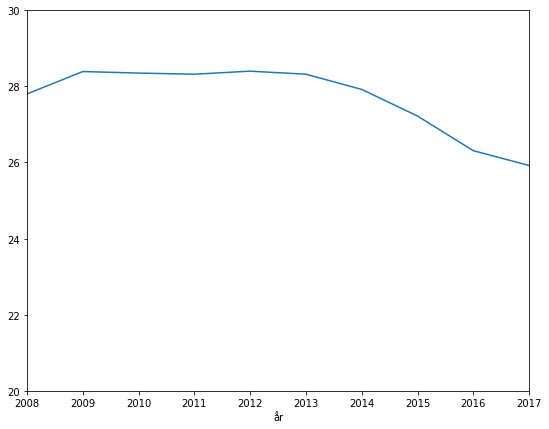

In [26]:

kom.andel_gamla.plot(figsize=(9,7))
plt.ylim(bottom=20,top=30)

Så en svag nedgån i andelen äldre som anställda i Sveriges kommuner de senaste 10 åren!

In [27]:
# Skillnad mellan 2017 och 2008 i antalet anställda 55-plusare i kommunerna
kom.loc[kom.index==2017,'antal_55-'].values[0] - kom.loc[kom.index==2008,'antal_55-'].values[0]

-750

In [28]:
# Totalt antal anställda 55-plusare i kommun och landsting 2017
kom.loc[kom.index==2017,'antal_55-'].values[0]+län.loc[län.index==2017,'antal_55-'].values[0]

269105

In [29]:
# Skillnad i procenenheter i andelen gamla 2017 jämfört 2008 i kommunerna
(kom.loc[kom.index==2017,'andel_gamla'].values[0] - kom.loc[kom.index==2008,'andel_gamla'].values[0]).round(1)

-1.9

In [30]:
# Andelen 55-plusare i riket 2017
(((kom.loc[kom.index==2017,'antal_55-'].values[0]+län.loc[län.index==2017,'antal_55-'].values[0])\
/(kom.loc[kom.index==2017,'antal'].values[0]+län.loc[län.index==2017,'antal'].values[0]))*100).round(1)

26.3

In [31]:
# Andelen 55-plusare i kommunerna 2017
((kom.loc[kom.index==2017,'antal_55-'].values[0]/kom.loc[kom.index==2017,'antal'].values[0])*100).round(1)

25.9

In [32]:
def results(df,year=2017):
    df = df.reset_index()[df.reset_index()['reg']!='Totalt'].set_index('reg')
    
    start = df.år.min()
    
    tmp = calc(df).reset_index()[['reg','år', 'andel_55-']]
    resultat = tmp.pivot_table(index='reg',columns='år')
    
    
    
    resultat.columns = resultat.columns.droplevel()
    resultat['diff'] = resultat[year]-resultat[start]
    
    resultat = resultat.reset_index()[['reg',year,'diff']]\
                    .sort_values(year,ascending=False).reset_index(drop=True)
    
    tmp = calc(df).reset_index()[['reg','år','antal_55-']]
    tmp = tmp.loc[tmp['år']==year,['reg','antal_55-']]
    
    resultat = resultat.merge(tmp,on='reg',how='left')
    
    resultat = resultat[['reg','antal_55-',year,'diff']]
    resultat.columns = ['Region/kommun','Antal anställda 55 år+',
                        'Andel anställda 55 år+',f"Förändring {start}-2017, %-enheter"]
    
    return resultat

In [33]:
results(dfk).head()

,Region/kommun,Antal anställda 55 år+,Andel anställda 55 år+,"Förändring 2008-2017, %-enheter"
0,Pajala,278,41.1,8.34
1,Övertorneå,202,40.6,10.60
2,Skinnskatteberg,145,38.3,7.90
3,Åsele,117,36.2,3.53
4,Smedjebacken,290,35.8,0.66


In [35]:
if not os.path.isdir('res'):
    os.makedirs('res')

In [36]:
# Spara till resultatfiler
results(dfk).to_excel('res/kommuner.xlsx',index=False)
results(dfr).to_excel('res/regioner.xlsx',index=False)

In [37]:
df = results(dfk)

In [38]:
# Antalet kommuner där andelen 55-plusare ökat sedan 2008
df[df['Förändring 2008-2017, %-enheter']>0].shape

(66, 4)

In [39]:
# Antalet kommuner som har större andel 55-plusare 2017 jämfört med genomsnittet i Sveriges kommuner
df[df['Andel anställda 55 år+']>(25.9)].shape

(167, 4)

In [40]:
dåliga = df[df['Förändring 2008-2017, %-enheter']>0]['Region/kommun'].tolist()

In [41]:
df = calc(dfk[dfk.index.isin(dåliga)]).reset_index()

In [42]:
df1 = df[['reg','år','antal','antal_55-']].groupby(['år']).sum()
tmp = df[df['reg']!='Stockholm'][['reg','år','antal','antal_55-']].groupby(['år']).sum()
sthlm = df[df['reg']=='Stockholm'][['reg','år','antal','antal_55-']].groupby(['år']).sum()

In [43]:
df1['andel']=((df1['antal_55-']/df1['antal'])*100).round(1)
tmp['andel']=((tmp['antal_55-']/tmp['antal'])*100).round(1)
sthlm['andel']=((sthlm['antal_55-']/sthlm['antal'])*100).round(1)

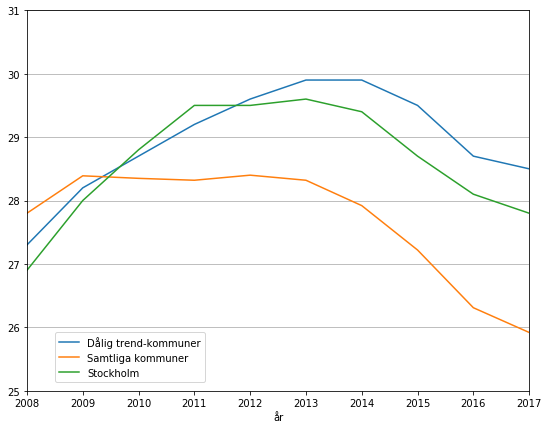

In [44]:
fig, ax = plt.subplots(figsize=(9,7))

df1.rename(columns={'andel':'Dålig trend-kommuner'})['Dålig trend-kommuner'].plot(ax=ax)
kom.rename(columns={'andel_gamla':'Samtliga kommuner'})['Samtliga kommuner'].plot(ax=ax)
sthlm.rename(columns={'andel':'Stockholm'})['Stockholm'].plot(ax=ax)
plt.ylim(bottom=25,top=31)
plt.grid(True,axis='y')
fig.legend(loc=(0.1,0.11))
plt.savefig('plot.png')

Trendkuran ovan visar att andelen äldre i kommunernas förvaltning ökade 2009 och nådde sedan en topp 2012, men har sedan dess sjunkit. Lägesbilden blir med andra ord inte värre. Men enskilda kommuner går emot denna övergripande trend – i 66 kommuner ökar andelen äldre. I Övertorneå ökade exempelvis andelen anställda 55 år+ med 10 procentenheter de senaste tio åren – och det var från en redan hög nivå. Vi valde därför att fokusera på dessa kommuners utmaning.

In [45]:
kom.reset_index().to_excel('res/riket.xlsx',index=False)